In [2]:
%pip install kaggle --quiet
!kaggle datasets download -d andrewmvd/animal-faces

import zipfile
from pathlib import Path

zip_path = Path("animal-faces.zip")
out_dir = Path("animal-faces")

out_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path) as z:
    z.extractall(out_dir)


Note: you may need to restart the kernel to use updated packages.
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)




  0%|          | 0.00/696M [00:00<?, ?B/s]
 21%|██▏       | 149M/696M [00:00<00:00, 1.55GB/s]
 45%|████▌     | 316M/696M [00:00<00:00, 1.67GB/s]
 70%|███████   | 489M/696M [00:00<00:00, 1.73GB/s]
 94%|█████████▍| 654M/696M [00:00<00:00, 1.70GB/s]
100%|██████████| 696M/696M [00:00<00:00, 1.69GB/s]


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
image_path = []
labels = []

for i in os.listdir("animal-faces/afhq"):
    for label in os.listdir(f"animal-faces/afhq/{i}"):
        for image in os.listdir(f"animal-faces/afhq/{i}/{label}"):
            image_path.append(f"animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)
            
data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,animal-faces/afhq/train/cat/flickr_cat_000002.jpg,cat
1,animal-faces/afhq/train/cat/flickr_cat_000003.jpg,cat
2,animal-faces/afhq/train/cat/flickr_cat_000004.jpg,cat
3,animal-faces/afhq/train/cat/flickr_cat_000005.jpg,cat
4,animal-faces/afhq/train/cat/flickr_cat_000006.jpg,cat


In [4]:
train = data_df.sample(frac=0.7)    # Alternative to train_test_split, gives output as dataframe instead of lists.
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index, 0]
        label = self.labels[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)
        
        return image, label

In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=image_transforms)
test_dataset = CustomImageDataset(dataframe=test, transform=image_transforms)
val_dataset = CustomImageDataset(dataframe=val, transform=image_transforms)

In [8]:
train_dataset.__getitem__(7)

(tensor([[[0.5569, 0.5569, 0.5451,  ..., 0.4157, 0.4275, 0.4431],
          [0.5765, 0.5843, 0.5765,  ..., 0.4078, 0.4235, 0.4471],
          [0.5922, 0.5922, 0.5882,  ..., 0.4157, 0.4392, 0.4667],
          ...,
          [0.6314, 0.6078, 0.5961,  ..., 0.6235, 0.5804, 0.5176],
          [0.5804, 0.5294, 0.4902,  ..., 0.6353, 0.5686, 0.4980],
          [0.4980, 0.4353, 0.4118,  ..., 0.6118, 0.5647, 0.4902]],
 
         [[0.5333, 0.5333, 0.5216,  ..., 0.4745, 0.4745, 0.4824],
          [0.5490, 0.5529, 0.5451,  ..., 0.4588, 0.4667, 0.4784],
          [0.5569, 0.5608, 0.5529,  ..., 0.4588, 0.4745, 0.4902],
          ...,
          [0.4745, 0.4588, 0.4471,  ..., 0.5176, 0.5451, 0.5686],
          [0.4314, 0.3843, 0.3451,  ..., 0.5294, 0.5294, 0.5490],
          [0.3608, 0.2941, 0.2667,  ..., 0.5255, 0.5451, 0.5608]],
 
         [[0.4431, 0.4431, 0.4314,  ..., 0.3216, 0.3294, 0.3529],
          [0.4863, 0.4941, 0.4863,  ..., 0.3020, 0.3137, 0.3490],
          [0.5176, 0.5216, 0.5137,  ...,

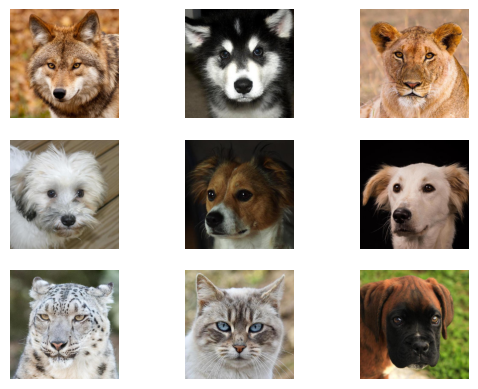

In [9]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n = 1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

In [10]:
LR = 1e-4   # Learning rate
BATCH_SIZE = 16
EPOCHS = 10

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Creating the model:

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear = nn.Linear((128 * 16 * 16), 128)
        self.flatten = nn.Flatten()  

        self.relu = nn.ReLU()

        self.output = nn.Linear(128, len(data_df["labels"].unique()))
    
    def forward(self, x):
        x = self.conv1(x)   # -> (32, 128, 128)
        x = self.pooling(x) # -> (32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x)   # -> (64, 64, 64)
        x = self.pooling(x) # -> (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x)   # -> (128, 32, 32)
        x = self.pooling(x) # -> (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x) # -> (128 * 16 * 16)
        x = self.linear(x)  # -> (128)
        x = self.output(x)  # -> (prediction)
        
        return x

In [16]:
model = Net().to(device)

In [17]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [20]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss_train += loss.item()
        loss.backward()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss_val += loss.item()

            acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += acc
    
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))

    total_acc_train_plot.append(round((total_acc_train / len(train_dataset)) * 100, 4))
    total_acc_validation_plot.append(round((total_acc_val / len(val_dataset)) * 100, 4))

    print(f'''Epoch no. {epoch + 1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}
    Validation Loss: {round(total_loss_val/1000, 4)}, Validation Accuracy: {round(total_acc_val/val_dataset.__len__() * 100, 4)}''')

    print("-" * 50)



Epoch no. 1/10, Train Loss: 0.333, Train Accuracy: 80.4889
    Validation Loss: 0.0422, Validation Accuracy: 89.2562
--------------------------------------------------
Epoch no. 2/10, Train Loss: 0.1421, Train Accuracy: 92.5693
    Validation Loss: 0.0294, Validation Accuracy: 93.3471
--------------------------------------------------
Epoch no. 3/10, Train Loss: 0.0959, Train Accuracy: 95.0137
    Validation Loss: 0.0229, Validation Accuracy: 94.2975
--------------------------------------------------
Epoch no. 4/10, Train Loss: 0.0677, Train Accuracy: 96.6522
    Validation Loss: 0.0224, Validation Accuracy: 94.7521
--------------------------------------------------
Epoch no. 5/10, Train Loss: 0.0504, Train Accuracy: 97.4759
    Validation Loss: 0.0189, Validation Accuracy: 95.6198
--------------------------------------------------
Epoch no. 6/10, Train Loss: 0.0382, Train Accuracy: 97.9984
    Validation Loss: 0.0225, Validation Accuracy: 95.0413
--------------------------------------

In [22]:
with torch.no_grad():
    total_acc_test = 0
    total_loss_test = 0

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss_test += loss.item()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test / len(test_dataset)) * 100, 4)}% & loss is: {round(total_loss_test / 1000, 4)}")

Accuracy Score is: 96.4035% & loss is: 0.0201


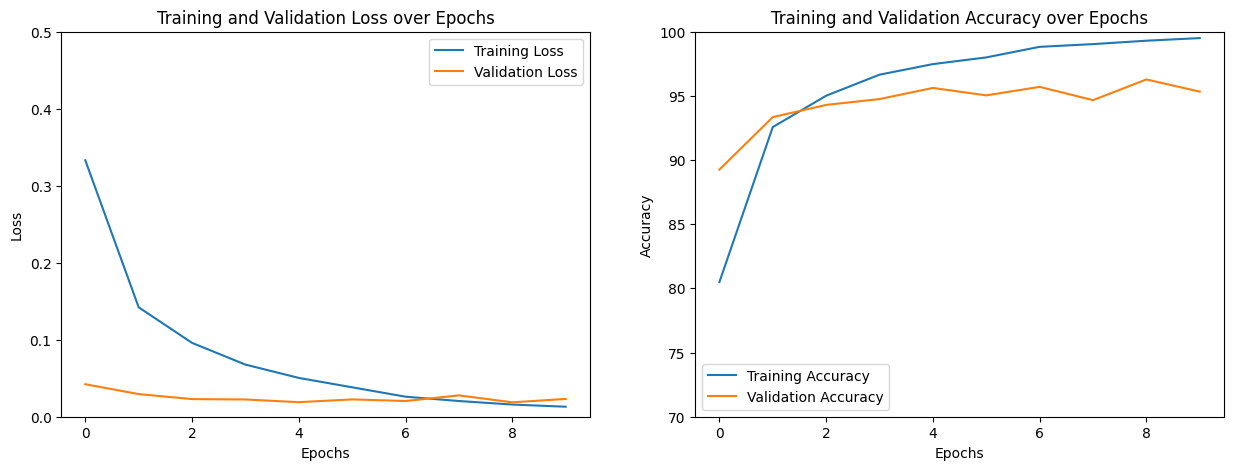

In [26]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotting loss over epochs
axis[0].plot(total_loss_train_plot, label="Training Loss")
axis[0].plot(total_loss_validation_plot, label="Validation Loss")
axis[0].set_title("Training and Validation Loss over Epochs")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_ylim([0, 0.5])
axis[0].legend()

# Plotting accuracy over epochs
axis[1].plot(total_acc_train_plot, label="Training Accuracy")
axis[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axis[1].set_title("Training and Validation Accuracy over Epochs")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_ylim([70, 100])
axis[1].legend()

plt.show()

Inference

In [ ]:
image_path = "alpaca.png"

with open(image_path, "wb") as f:
    image_path = "alpaca-8108043_1280.png"
# Preprocess the image
image = Image.open(image_path).convert("RGB")
image = image_transforms(image).unsqueeze(0).to(device)  # Add batch dimension

# Perform inference
model.eval()
with torch.no_grad():
    output = model(image)
    predicted_label = torch.argmax(output, axis=1).item()

# Decode the label
decoded_label = label_encoder.inverse_transform([predicted_label])[0]
print(f"The predicted label for the image is: {decoded_label}")

The predicted label for the image is: wild
